# PRISM: Populate DB and Initial Processing

Read in the PRISM stuff and populate the DB with the PRISM info. Also need to start processing these data for distributions and so forth.

In [1]:
# this tells Jupyter to embed matplotlib plots in the notebook
%matplotlib notebook

In [2]:
import os
import geopandas as gpd
from copy import deepcopy
from IPython.display import display, HTML, Image
import netCDF4
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
import shapely as sp
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.geometry import Polygon

In [3]:
import pyodbc
import sqlalchemy

In [4]:
import pytz

In [5]:
import DBA_DClimComp as DBAD

In [6]:
IN_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
         r'charge\Data\Weather\PRISM_Daily'
PTS_SHP = "AOI_PRISM_Pts.shp"
gpd_PTS = gpd.read_file( os.path.normpath( os.path.join( IN_DIR, PTS_SHP ) ) )
gpd_PTS.crs

{'init': 'epsg:32614'}

In [22]:
# Spreadsheets
XLSX_Dict = { "precip" : "PRISM_AOI_Pts_ppt.xlsx", 
              "tmax" : "PRISM_AOI_Pts_tmax.xlsx",
              "tmin" : "PRISM_AOI_Pts_tmin-Processed.xlsx",
              "tmean" : "PRISM_AOI_Pts_tmean.xlsx",
              "tdmean" : "PRISM_AOI_Pts_tdmean.xlsx",
              "vpdmax" : "PRISM_AOI_Pts_vpdmax.xlsx",
              "vpdmin" : "PRISM_AOI_Pts_vpdmin-Processed.xlsx",
            }
IN_SHEET = 'Daily'

In [8]:
NLDAS_GRID = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\CM' \
             r'IP5\NLDAS_Grid_Reference\NLDAS_Grid_Reference.shp'
gpd_NLDAS = gpd.read_file( NLDAS_GRID )
degCRS = gpd_NLDAS.crs
gpd_NLDAS.crs

{'init': 'epsg:4326'}

## PRISM Units

[PRISM Units](http://prism.oregonstate.edu/FAQ/)

"Dataset values are stored in the standard metric units used for climatology: precipitation as millimeters and temperature as degrees Celsius. In creating map graphics, we convert those values to inches and degrees Fahrenheit for you, since most users want maps in those units."

Vapor Pressure Deficit is in **hPa**. An **hPA** is a Hectopascals or 100 Pascals.

- "AN81d" (daily time series)

The long-term average datasets discussed above are modeled with PRISM using a DEM as the predictor grid.  In contrast, the time series datasets are modeled using a method called climatologically-aided interpolation (CAI).  In CAI, the long-term average datasets serve as the predictor grids.  The idea behind CAI is that the best first guess of the spatial pattern of climatic conditions for a given month or day is the long-term average pattern.  CAI is robust to wide variations in station data density, which is necessary when modeling century-long time series.


[Vapor-pressure deficit](https://en.wikipedia.org/wiki/Vapour-pressure_deficit)
Vapour-pressure deficit, or VPD, is the difference (deficit) between the amount of moisture in the air and how much moisture the air can hold when it is saturated. Once air becomes saturated, water will condense out to form clouds, dew or films of water over leaves. It is this last instance that makes VPD important for greenhouse regulation. If a film of water forms on a plant leaf, it becomes far more susceptible to rot. On the other hand, as the VPD increases, the plant needs to draw more water from its roots. In the case of cuttings, the plant may dry out and die. For this reason the ideal range for VPD in a greenhouse is from 0.45 kPa to 1.25 kPa, ideally sitting at around 0.85 kPa. As a general rule, most plants grow well at VPDs of between 0.8 and 0.95 kPa.[citation needed]

In ecology, it is the difference between the actual water vapour pressure and the saturation water vapour pressure at a particular temperature. Unlike relative humidity, vapour-pressure deficit has a simple nearly straight-line relationship to the rate of evapotranspiration and other measures of evaporation. 

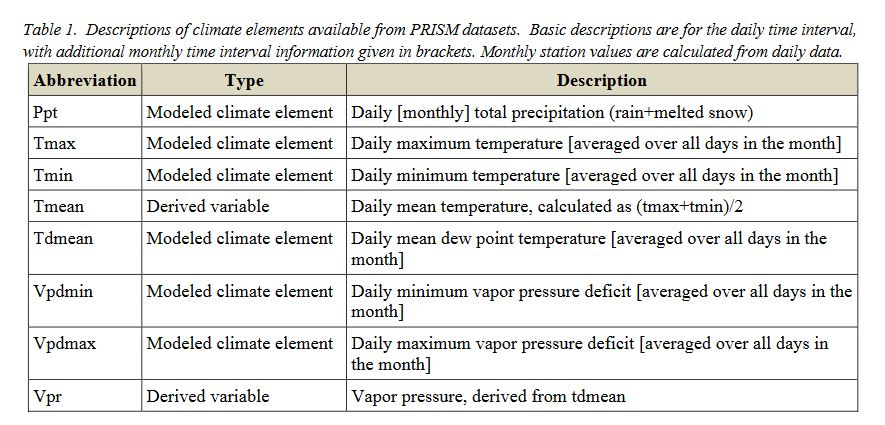

In [9]:
ImPath = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Rechar' \
         r'ge\Data\Weather\PRISM_Daily\PRISM_Definitions.JPG'
display( Image(filename=ImPath, width=700 ) )

## Process the Grid Points

In [10]:
NumGPts = len( gpd_PTS )
NumGPts

210

In [11]:
display( HTML( gpd_PTS.head().to_html() ) )

,Index1,New_Area_m,POINT_X,POINT_Y,geometry
0,662328,1.701255e+07,291619.224703,3.353093e+06,POINT (291619.2247031514 3353093.044753992)
1,662329,1.696173e+07,295627.465299,3.353017e+06,POINT (295627.4652986222 3353017.290083501)
2,662330,1.691092e+07,299635.652424,3.352943e+06,POINT (299635.6524244148 3352943.008720022)
3,662331,1.686013e+07,303643.787128,3.352870e+06,POINT (303643.7871283953 3352870.200525675)
4,662332,1.680936e+07,307651.870458,3.352799e+06,POINT (307651.870458468 3352798.865365324)


Now convert to the same as NLDAS so can have coordinates in degrees as well.

In [12]:
gpd_PTSDegs = gpd_PTS.to_crs( degCRS )

In [13]:
PtX = lambda Pt: Pt.x
PtY = lambda Pt: Pt.y

In [14]:
gpd_PTSDegs[DBAD.FIELDN_LON] = gpd_PTSDegs.apply( lambda row: PtX(row['geometry']), axis=1 )
gpd_PTSDegs[DBAD.FIELDN_LAT] = gpd_PTSDegs.apply( lambda row: PtY(row['geometry']), axis=1 )

In [15]:
display( HTML( gpd_PTSDegs.head().to_html() ) )

,Index1,New_Area_m,POINT_X,POINT_Y,geometry,Longitude,Lattitude
0,662328,1.701255e+07,291619.224703,3.353093e+06,POINT (-101.1666666666476 30.29166666665069),-101.166667,30.291667
1,662329,1.696173e+07,295627.465299,3.353017e+06,POINT (-101.1249999999809 30.2916666666507),-101.125000,30.291667
2,662330,1.691092e+07,299635.652424,3.352943e+06,POINT (-101.0833333333142 30.2916666666507),-101.083333,30.291667
3,662331,1.686013e+07,303643.787128,3.352870e+06,POINT (-101.0416666666475 30.29166666665069),-101.041667,30.291667
4,662332,1.680936e+07,307651.870458,3.352799e+06,POINT (-100.9999999999808 30.2916666666507),-101.000000,30.291667


Make the DataFrame that will use to populate the database for the Grid point metadata table.

In [16]:
DataDict = { DBAD.FIELDN_GRIDIND : np.array( gpd_PTS["Index1"], dtype=np.int32 ),
             DBAD.FIELDN_LON : np.array( gpd_PTSDegs[DBAD.FIELDN_LON], dtype=np.float32 ),
             DBAD.FIELDN_LAT : np.array( gpd_PTSDegs[DBAD.FIELDN_LAT], dtype=np.float32 ),
             DBAD.FIELDN_X : np.array( gpd_PTS["POINT_X"], dtype=np.float32 ), 
             DBAD.FIELDN_Y : np.array( gpd_PTS["POINT_Y"], dtype=np.float32 ), 
}

In [17]:
MasterGridDF = pd.DataFrame( data=DataDict )

In [18]:
display( HTML( MasterGridDF.to_html() ) )

,Grid_Index,Longitude,Lattitude,utm_x,utm_y
0,662328,-101.166664,30.291666,291619.21875,3353093.00
1,662329,-101.125000,30.291666,295627.46875,3353017.25
2,662330,-101.083336,30.291666,299635.65625,3352943.00
3,662331,-101.041664,30.291666,303643.78125,3352870.25
4,662332,-101.000000,30.291666,307651.87500,3352798.75
5,662333,-100.958336,30.291666,311659.90625,3352729.00
6,662334,-100.916664,30.291666,315667.87500,3352660.50
7,662335,-100.875000,30.291666,319675.81250,3352593.75
8,662336,-100.833336,30.291666,323683.71875,3352528.25
9,662337,-100.791664,30.291666,327691.56250,3352464.25


In [19]:
#engine = sqlalchemy.create_engine( DBAD.DSN_STRING )

In [ ]:
# metadata only needs to be added one time to the database so can keep this commented out unless
#   need to delete that table for some reason.
#MasterGridDF.to_sql( DBAD.PRISM_PTMETA, engine, schema=DBAD.PRISM_SCHEMA, if_exists='append', 
#                     index=False )

## Process the Data Files

In PRISM acquisition process the data archives were converted directly to spreadsheets. Read in the spreadsheet for each data type and then update the data tables.

In [23]:
DataKeys = sorted( XLSX_Dict.keys() )
DataKeys

['precip', 'tdmean', 'tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin']

In [24]:
tDKeys = deepcopy( DataKeys[4:] )
tDKeys

['tmin', 'vpdmax', 'vpdmin']

In [25]:
for tKey in tDKeys:
    print("Working on %s, start time %s" % 
          (tKey, (dt.datetime.now()).strftime("%m/%d/%Y %H:%M:%S") ) )
    InPFile = os.path.normpath( os.path.join( IN_DIR, XLSX_Dict[tKey] ) )
    InDF = pd.read_excel( InPFile, sheet_name=IN_SHEET, header=0, parse_dates=[0] )
    OurDFList = list()
    # 'precip', 'tdmean', 'tmax', 'tmean', 'tmin', 'vpdmax', 'vpdmin'
    if tKey == 'precip':
        valName = DBAD.FIELDN_PVAL
        tableName = DBAD.PRISM_PRECIP
    elif tKey == 'tmax':
        valName = DBAD.FIELDN_TMXVAL
        tableName = DBAD.PRISM_TMAX
    elif tKey == 'tmin':
        valName = DBAD.FIELDN_TMNVAL
        tableName = DBAD.PRISM_TMIN
    elif tKey == 'tmean':
        valName = DBAD.FIELDN_TAVEVAL
        tableName = DBAD.PRISM_TMEAN
    elif tKey == 'tdmean':
        valName = DBAD.FIELDN_TDPT
        tableName = DBAD.PRISM_TDMEAN
    elif tKey == 'vpdmax':
        valName = DBAD.FIELDN_VPDMX
        tableName = DBAD.PRISM_VPDMAX
    elif tKey == 'vpdmin':
        valName = DBAD.FIELDN_VPDMN
        tableName = DBAD.PRISM_VPDMIN
    else:
        print("Invalid key values of %s" % tKey )
        continue
    # if made it here then go through by column
    NumTimes = len( InDF )
    if NumTimes < 1:
        print("Did not find any valid times!!!")
        continue
    # extract our times because have the same times for all
    DTList = InDF["DateTime_UTC"].tolist()
    UTCDTList = [ pd.to_datetime(x).tz_localize(pytz.utc) for x in DTList ]
    # get our columns
    OurCols = InDF.columns.tolist()
    OurCols.pop(0)
    # now loop through by grid column
    for gID in OurCols:
        # get our foreign key values
        oRow = MasterGridDF.loc[MasterGridDF[DBAD.FIELDN_GRIDIND] == gID ]
        oFk = int( oRow.index[0] ) + 1
        Fkar = oFk * np.ones( NumTimes, dtype=np.int16 )
        # make our data dictionary
        DataDict = { DBAD.FIELDN_GNPK : Fkar,
                     DBAD.FIELDN_DT : UTCDTList,
                     valName : np.array( InDF[gID], dtype=np.float32 ),
                   }
        olDF = pd.DataFrame( data=DataDict )
        OurDFList.append( olDF )
    # end of inner for
    # concatenate
    cModelDF = pd.concat( OurDFList, ignore_index=True )
    # write to the db
    cModelDF.to_sql( tableName, engine, schema=DBAD.PRISM_SCHEMA, 
                     if_exists='append', index=False )
# end of outer for

Working on tmin, start time 07/15/2019 17:24:19
Working on vpdmax, start time 07/15/2019 17:33:28
Working on vpdmin, start time 07/15/2019 17:42:26
